# Chp 9: Part 3

## 9.4 Interpreting what convnets learn

### Visualizing intermediate activations

In [1]:
def is_jupyter_lab():
    import re
    import psutil
    return any(re.search('jupyter-lab', x) for x in psutil.Process().parent().cmdline())


if is_jupyter_lab():
    print("Using jupyter-lab. Click `Upload Files` in the file-explorer and upload `kaggle.json` manually")
else:
    # colab
    from google.colab import files
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !mkdir chp09_convnet


Using jupyter-lab. Click `Upload Files` in the file-explorer and upload `kaggle.json` manually


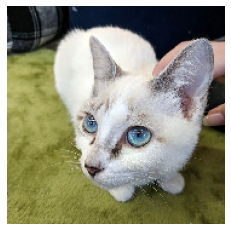

(1, 176, 176, 32)
Finished..


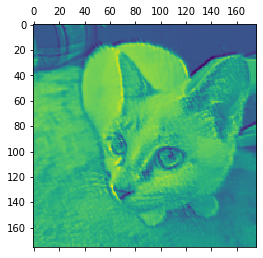

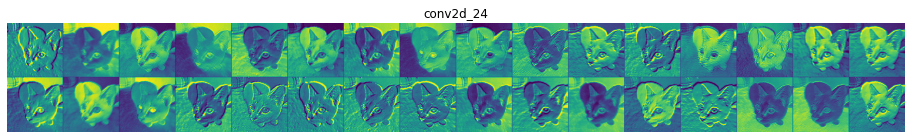

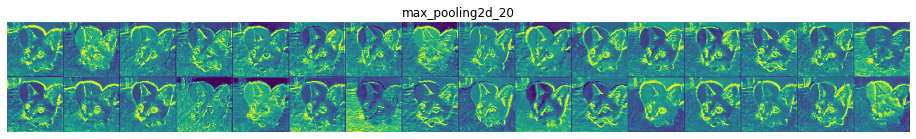

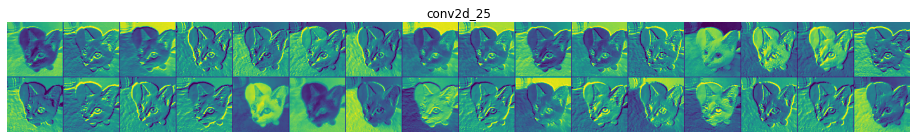

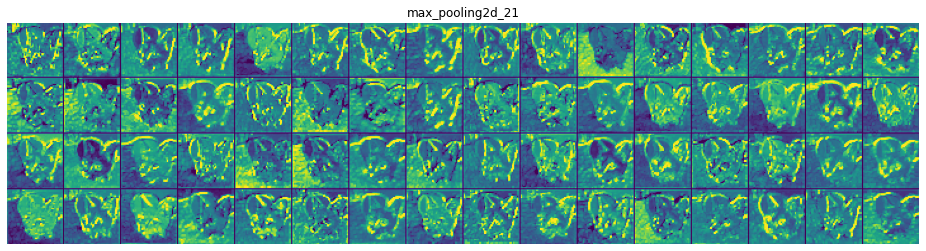

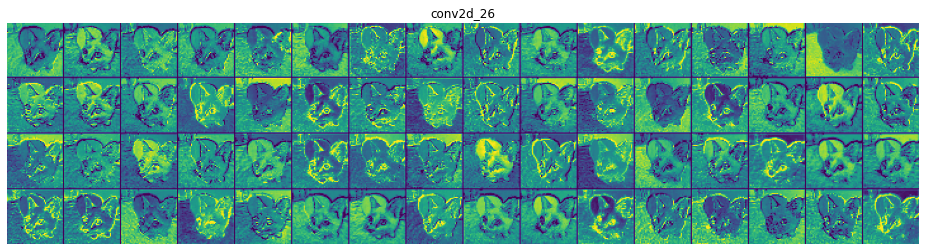

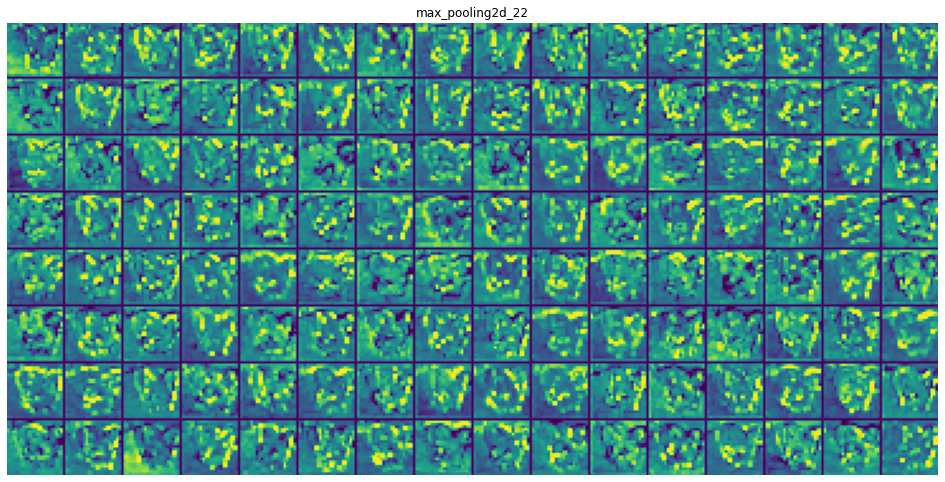

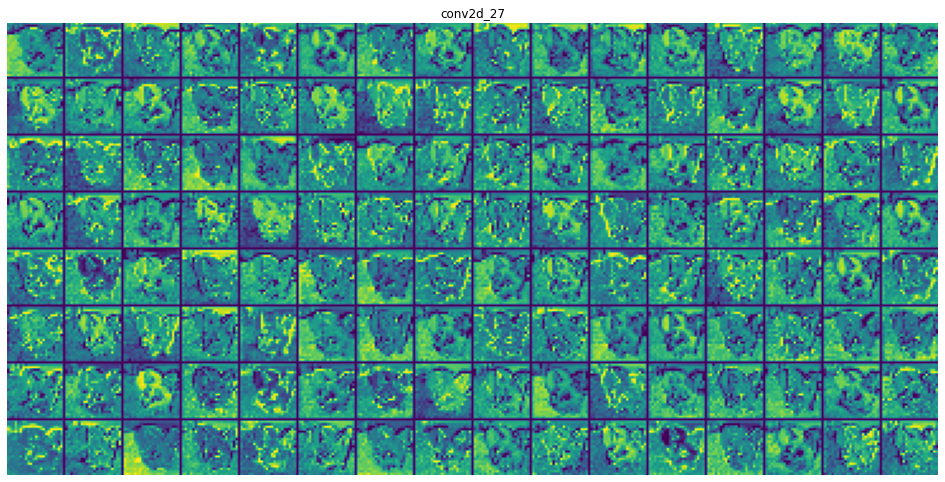

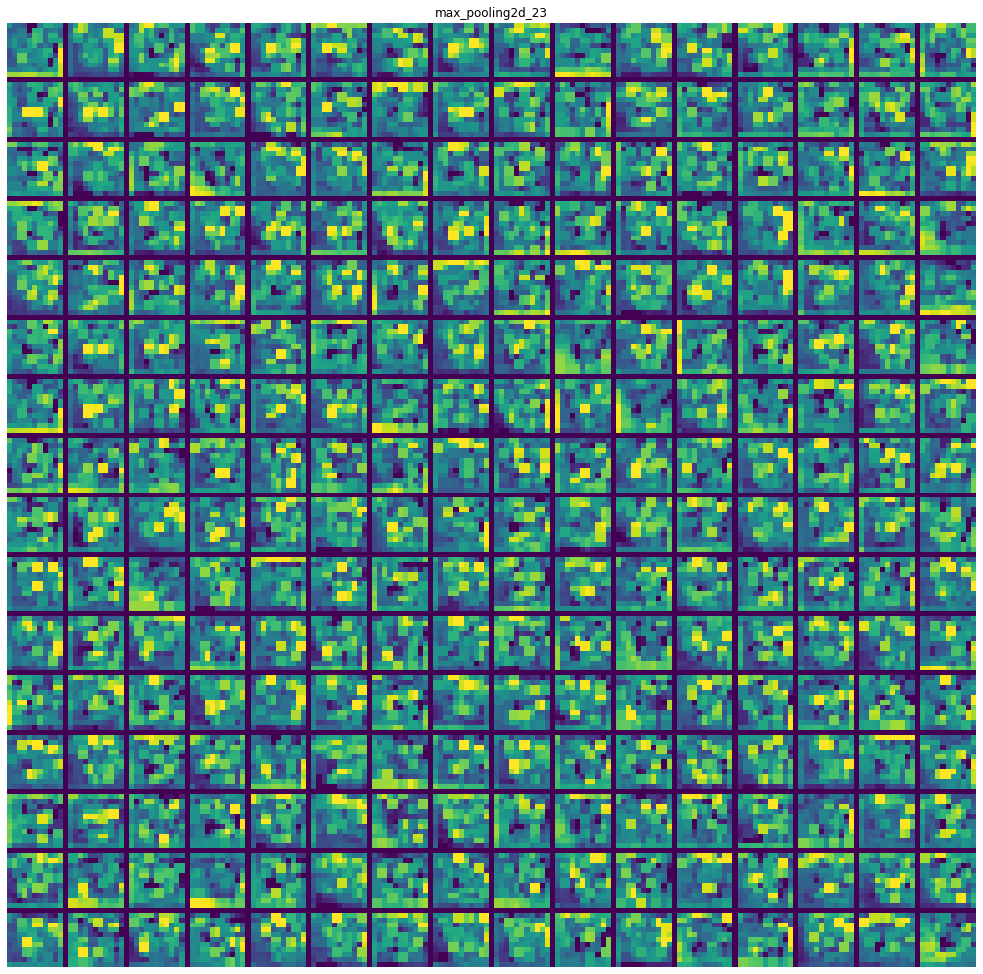

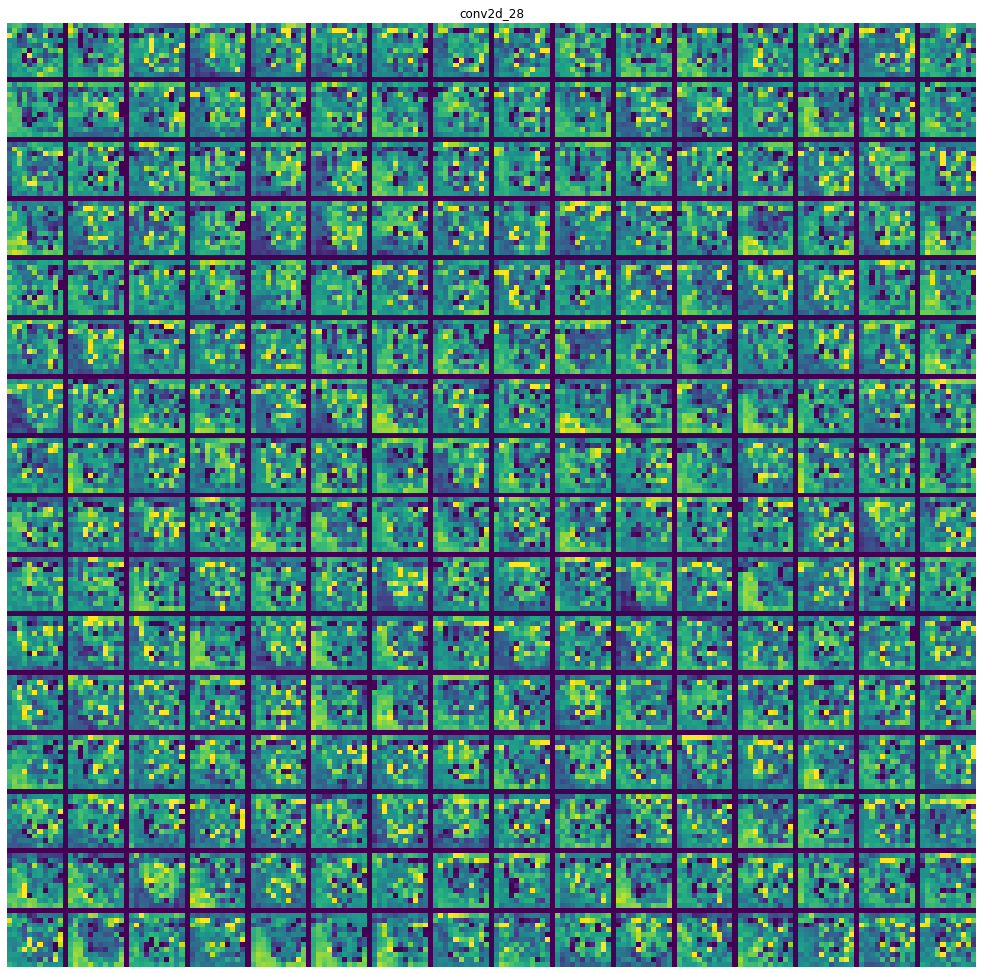

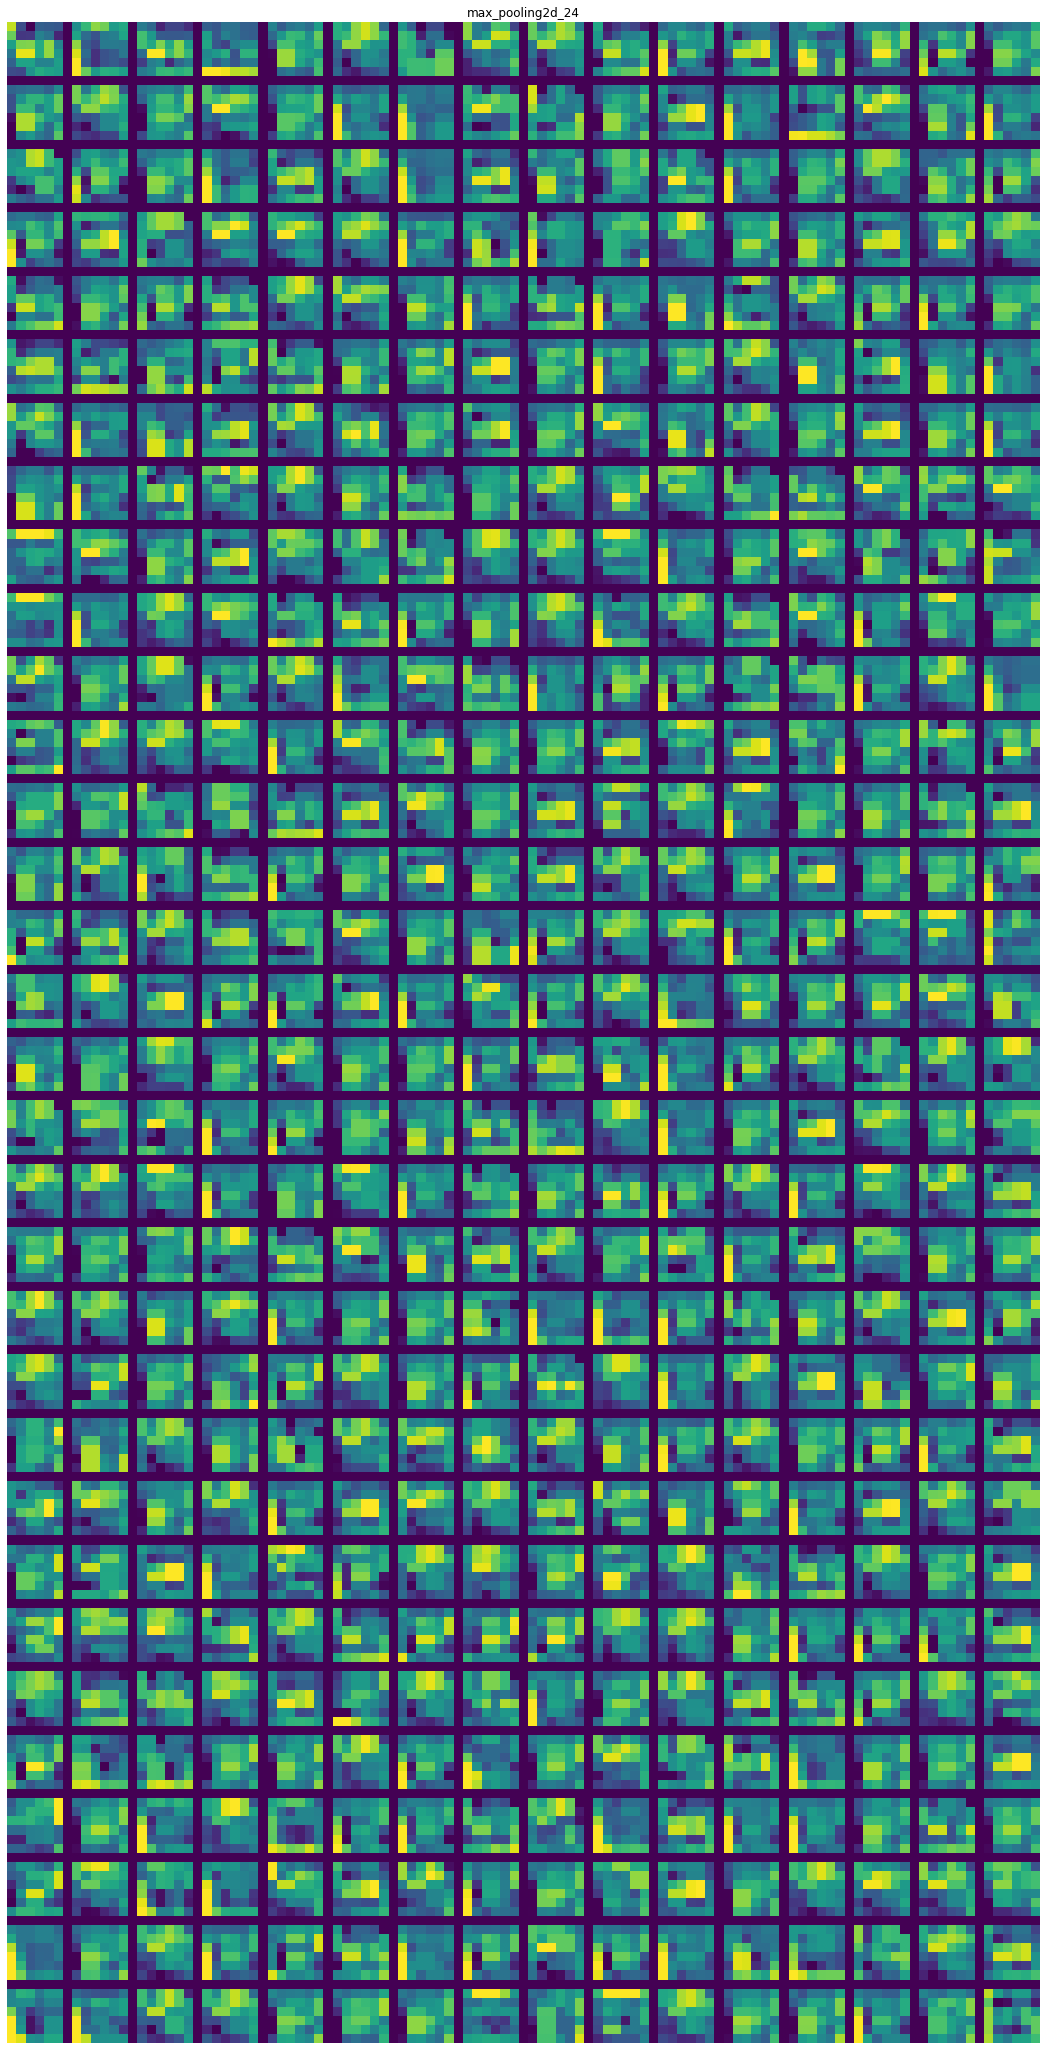

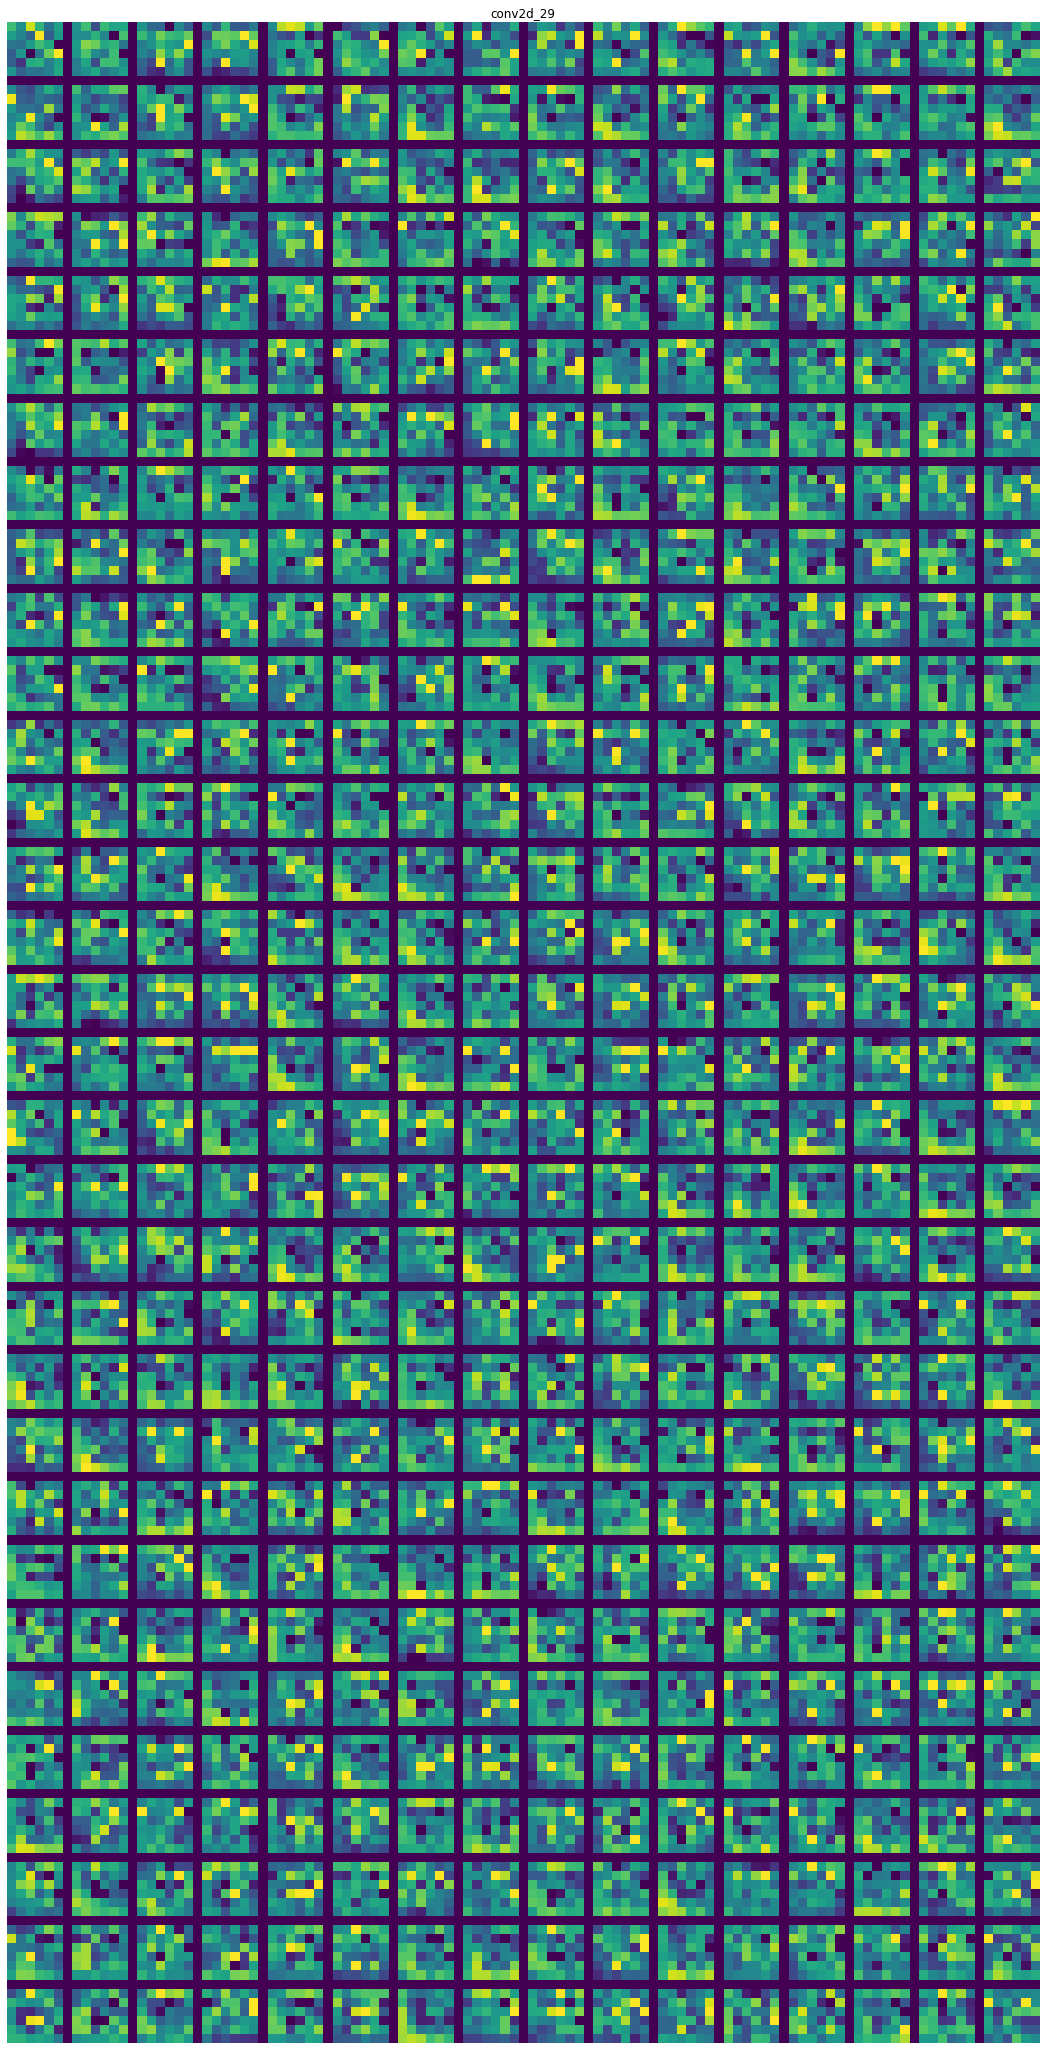

In [2]:
# You can use this to load the file "convnet_from_scratch_with_augmentation.keras"
# you obtained in the last chapter.

def listing9_6():
    from tensorflow import keras
    import numpy as np

    model = keras.models.load_model("chp09_convnet/chp9_convnet_patterns.keras")
    # model.summary()

    # Preprocessing a single image
    img_path = keras.utils.get_file(
        fname="cat.jpg",
        origin="https://img-datasets.s3.amazonaws.com/cat.jpg"
    )

    def get_img_array(img_path, target_size):
        img = keras.preprocessing.image.load_img(
            img_path, target_size=target_size
        )
        array = keras.preprocessing.image.img_to_array(img)
        array = np.expand_dims(array, axis=0)
        return array

    img_tensor = get_img_array(img_path, target_size=(180, 180))


    # Displaying the test picture
    import matplotlib.pyplot as plt
    plt.axis("off")
    plt.imshow(img_tensor[0].astype("uint8"))
    plt.show()

    
    # Instantiating a model that returns layer activations
    from tensorflow.keras import layers

    layer_outputs = []
    layer_names = []
    for layer in model.layers:
        if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)

    activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

    
    # Using the model to compute layer activations
    activations = activation_model.predict(img_tensor)
    first_layer_activation = activations[0]
    print(first_layer_activation.shape)
    
    
    # Visualizing the fifth channel
    import matplotlib.pyplot as plt
    plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")
    
    
    # Visualizing every channel in every intermediate activation
    images_per_row = 16
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros(((size + 1) * n_cols - 1,
                                 images_per_row * (size + 1) - 1))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_index = col * images_per_row + row
                channel_image = layer_activation[0, :, :, channel_index].copy()
                if channel_image.sum() != 0:
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype("uint8")
                display_grid[
                    col * (size + 1): (col + 1) * size + col,
                    row * (size + 1) : (row + 1) * size + row] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis("off")
        plt.imshow(display_grid, aspect="auto", cmap="viridis")
    
    print("Finished..")
    
    
    
listing9_6()

In [8]:
# Instantiating the Xception convolutional base

def listing9_12():

    from tensorflow import keras
    import numpy as np
    import matplotlib.pyplot as plt

    img_path = keras.utils.get_file(
        fname="cat.jpg",
        origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

    def get_img_array(img_path, target_size):
        img = keras.preprocessing.image.load_img(img_path, target_size=target_size)
        array = keras.preprocessing.image.img_to_array(img)
        array = np.expand_dims(array, axis=0)
        array = keras.applications.xception.preprocess_input(array)
        return array

    img_tensor = get_img_array(img_path, target_size=(180, 180))





    model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

    # Visualizing convnet filters
    # Instantiating the Xception convolutional base
    model = keras.applications.xception.Xception(
        weights="imagenet",
        include_top=False
    )

    # Visualizing convnet filters
    # Instantiating the Xception convolutional base
    model = keras.applications.xception.Xception(
        weights="imagenet",
        include_top=False
    ) 
    
    
    
    
    
    # Printing the names of all convolutional layers in Xception
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
            print(layer.name)    

    # Creating a "feature extractor" model that returns the output of a specific layer
    layer_name = "block3_sepconv1"
    layer = model.get_layer(name=layer_name)
    feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

    # Using the feature extractor
    activation = feature_extractor(
        keras.applications.xception.preprocess_input(img_tensor)
    )

    
    
    
    
    
    
    import tensorflow as tf

    def compute_loss(image, filter_index):
        activation = feature_extractor(image)
        filter_activation = activation[:, 2:-2, 2:-2, filter_index]
        return tf.reduce_mean(filter_activation)

    
    # Loss maximization via stochastic gradient ascent
    @tf.function
    def gradient_ascent_step(image, filter_index, learning_rate):
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss = compute_loss(image, filter_index)
        grads = tape.gradient(loss, image)
        grads = tf.math.l2_normalize(grads)
        image += learning_rate * grads
        return image
    
    
    # Function to generate filter visualizations
    img_width = 200
    img_height = 200

    def generate_filter_pattern(filter_index):
        iterations = 30
        learning_rate = 10.
        image = tf.random.uniform(
            minval=0.4,
            maxval=0.6,
            shape=(1, img_width, img_height, 3))
        for i in range(iterations):
            image = gradient_ascent_step(image, filter_index, learning_rate)
        return image[0].numpy()
    
    
    # Utility function to convert a tensor into a valid image
    def deprocess_image(image):
        image -= image.mean()
        image /= image.std()
        image *= 64
        image += 128
        image = np.clip(image, 0, 255).astype("uint8")
        image = image[25:-25, 25:-25, :]
        return image
    
    plt.axis("off")
    plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
    
    
    
    print('-------------------------------------')
    
    # Generating a grid of all filter response patterns in a layer
    
    all_images = []
    for filter_index in range(64):
        print(f"Processing filter {filter_index}")
        image = deprocess_image(
            generate_filter_pattern(filter_index)
        )
        all_images.append(image)

    margin = 5
    n = 8
    cropped_width = img_width - 25 * 2
    cropped_height = img_height - 25 * 2
    width = n * cropped_width + (n - 1) * margin
    height = n * cropped_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    for i in range(n):
        for j in range(n):
            image = all_images[i * n + j]
            stitched_filters[
                (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
                (cropped_height + margin) * j : (cropped_height + margin) * j
                + cropped_height,
                :,
            ] = image

    keras.preprocessing.image.save_img(
        f"filters_for_layer_{layer_name}.png", stitched_filters
    )    

    print('-------------------------------------')

#     plt.axis("off")
#     plt.imshow(f"filters_for_layer_{layer_name}.png", stitched_filters)
    
    
    
    print('Finished..')

listing9_12()

[('n02504458', 'African_elephant', 0.8699271), ('n01871265', 'tusker', 0.0769684), ('n02504013', 'Indian_elephant', 0.023537183)]
386


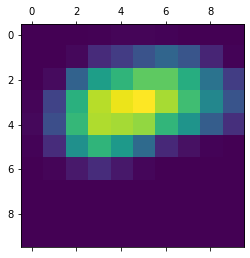

In [9]:
# Visualizing heatmaps of class activation
def listing9_20():
    import numpy as np
    import matplotlib.pyplot as plt
    from tensorflow import keras

    # Loading the Xception network with pretrained weights
    model = keras.applications.xception.Xception(weights="imagenet")
    
    # Preprocessing an input image for Xception
    img_path = keras.utils.get_file(
        fname="elephant.jpg",
        origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

    def get_img_array(img_path, target_size):
        img = keras.preprocessing.image.load_img(img_path, target_size=target_size)
        array = keras.preprocessing.image.img_to_array(img)
        array = np.expand_dims(array, axis=0)
        array = keras.applications.xception.preprocess_input(array)
        return array

    img_array = get_img_array(img_path, target_size=(299, 299))

    preds = model.predict(img_array)
    print(keras.applications.xception.decode_predictions(preds, top=3)[0])

    print(np.argmax(preds[0]))
    
    # Setting up a model that returns the last convolutional output
    last_conv_layer_name = "block14_sepconv2_act"
    classifier_layer_names = [
        "avg_pool",
        "predictions",
    ]
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    
    # Setting up a model that goes from the last convolutional output to the final predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    
    # Retrieving the gradients of the top predicted class with regard to the last convolutional output
    import tensorflow as tf

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    
    # Gradient pooling and channel importance weighting
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    
    # Heatmap post-processing
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)

    
    # Superimposing the heatmap with the original picture
    import matplotlib.cm as cm

    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    save_path = "elephant_cam.jpg"
    superimposed_img.save(save_path)

    
listing9_20()